In [1]:
import matplotlib.pyplot as plt
import numpy as np
from data_provider import data_provider
from alt_matrix_factor import MatrixFactorization
from run_multiple_models import run_mfs

In [2]:
provider = data_provider()
ratings = provider.get_ratings()

b'943 users\n1682 items\n100000 ratings\n'


In [3]:
ratings_sparse = ratings.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)
print(ratings_sparse.shape)
training_data_df, test_data_df = provider.split_dataframe(ratings_sparse, random_seed=42)
cross_validation_data = provider.cross_validation_split(training_data_df, holdout_fraction=0.2, random_seed=42)
training_data = training_data_df.to_numpy()
test_data = test_data_df.to_numpy()

print(training_data.shape)
print(training_data)
print(test_data.shape)

(943, 1682)
(849, 1682)
[[5 3 2 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [4 0 0 ... 0 0 0]
 [4 0 5 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(94, 1682)


In [4]:
mf = MatrixFactorization(training_data, 12, momentum=0, iterations=100, random_seed=42)
error = mf.train()

Iteration: 10 ; error = 0.7806
Iteration: 20 ; error = 0.7213
Iteration: 30 ; error = 0.6961
Iteration: 40 ; error = 0.6816
Iteration: 50 ; error = 0.6720
Iteration: 60 ; error = 0.6666
Iteration: 70 ; error = 0.6616
Iteration: 80 ; error = 0.6578
Iteration: 90 ; error = 0.6551
Iteration: 100 ; error = 0.6525


In [5]:
user_predicted_ratings = mf.get_prediction_matrix()
user_predicted_ratings.max()

12.792254532117703

0.6524578431079981


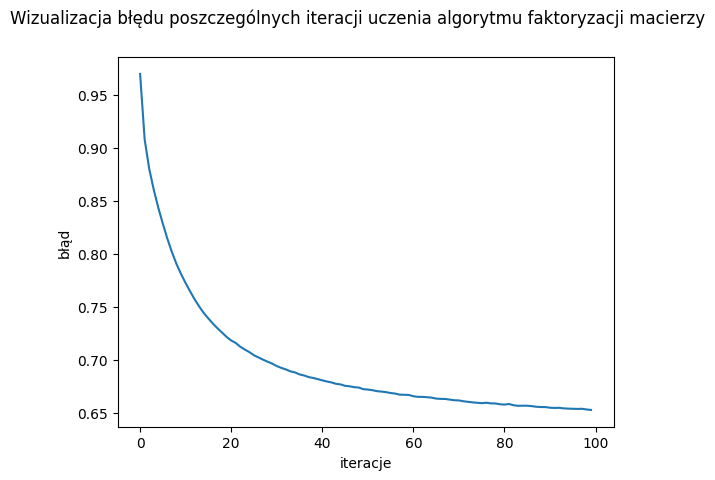

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.arange(1, len(error)+1), error)
ax.set_xlabel('iteracje')
ax.set_ylabel('błąd')
fig.suptitle('Wizualizacja błędu poszczególnych iteracji uczenia algorytmu faktoryzacji macierzy')
print(error[-1])

Test różnych współczynników uczenia

In [9]:
testing_learning_rates = [0.005, 0.01, 0.02, 0.04]

In [10]:
mfs = [MatrixFactorization(training_data, 12, learning_rate=rate, iterations=40, random_seed=42, momentum=0) for rate in testing_learning_rates]
test_results = run_mfs(mfs)

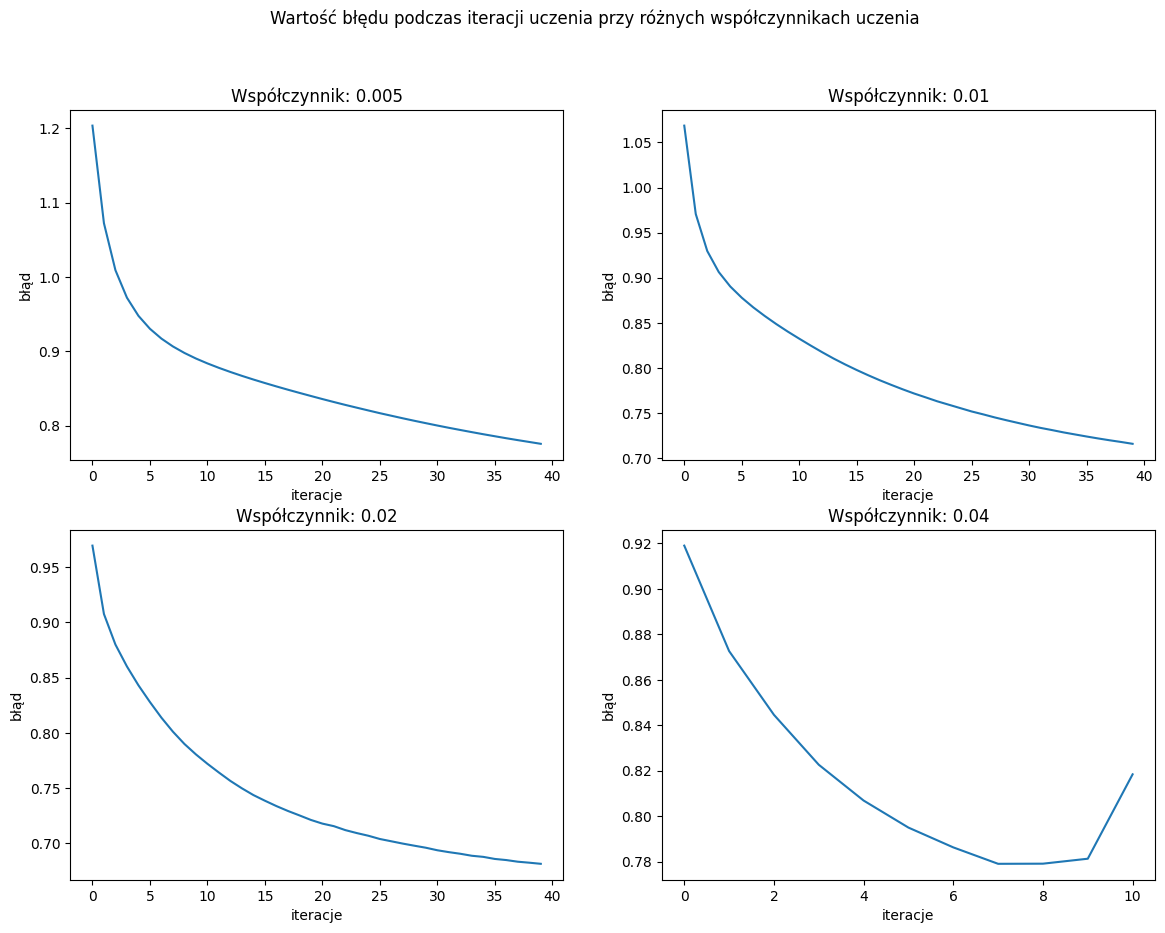

In [11]:
fig = plt.figure(figsize=(14,10))
fig.suptitle('Wartość błędu podczas iteracji uczenia przy różnych współczynnikach uczenia')
for index, result in enumerate(test_results):
    ax = fig.add_subplot(2,2,index+1)
    mf, error = result
    ax.plot(np.arange(1, len(error)+1), error)
    ax.set_xticks(np.arange(1, len(error)+1 ,2))
    ax.set_title('Współczynnik: '+str(mf.get_parameters()['learning_rate']))
    ax.set_xlabel('iteracje')
    ax.set_ylabel('błąd')
plt.show()

In [12]:
test_results[3]

(<alt_matrix_factor.Matrix_Factorization at 0x1cd4208dad0>,
 [0.9190369015849871,
  0.8726333847944904,
  0.8445738439270268,
  0.822599683888356,
  0.8068404146741204,
  0.7949352794958228,
  0.7862250252831113,
  0.7789910829554474,
  0.7790499362048221,
  0.7812326523290292,
  0.8183802830030683,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan])

In [4]:
testing_learning_rates2 = [0.001, 0.005, 0.01, 0.02]

In [7]:
cross_validation_result_lr = []
for learning_rate in testing_learning_rates2:
    mfs = []
    for training_data, _ in cross_validation_data:
        mf = MatrixFactorization(training_data, latent_factors=12, learning_rate=learning_rate, iterations=40, random_seed=42)
        mfs.append(mf)
    test_results = run_mfs(mfs)
    train_errors = []
    validation_errors = []
    for index, result in enumerate(test_results):
        mf, train_error = result
        training_data, validation_data = cross_validation_data[index]
        validation_error, _, _ = mf.get_rmse_and_similarity(validation_data)
        train_errors.append(train_error[-1])
        validation_errors.append(validation_error)
    train_error_mean = np.array(train_errors).mean()
    validation_error_mean = np.array(validation_errors).mean()
    cross_validation_result_lr.append([learning_rate, train_error_mean, validation_error_mean])
print(cross_validation_result_lr)

[[0.001, 0.8922601561184518, 1.132059508301036], [0.005, 0.7506449180895054, 1.1501261536333836], [0.01, 0.6897544313804526, 1.1755886180663528], [0.02, 0.658778019014113, 1.2000625034673473]]


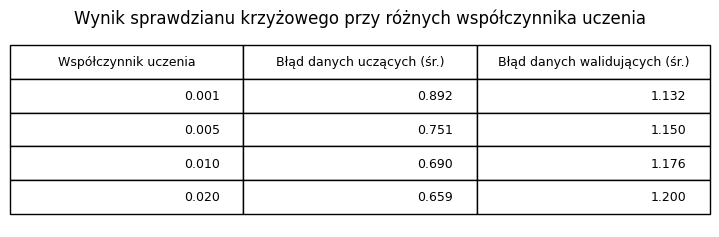

In [8]:
cross_validation_result_lr = [[round(j, 3) for j in i] for i in cross_validation_result_lr]
fig, ax = plt.subplots(figsize=(10,5))
table_data = [['{:.3f}'.format(j) for j in i] for i in cross_validation_result_lr]
table = plt.table(cellText=table_data, colLabels=['Współczynnik uczenia', 'Błąd danych uczących (śr.)', 'Błąd danych walidujących (śr.)'], loc='center')
table.scale(1,4)
plt.title('Wynik sprawdzianu krzyżowego przy różnych współczynnika uczenia')
plt.subplots_adjust(left=0.2, top=0.5)
plt.axis('off')
plt.show()

Test iteracji uczenia

In [4]:
test_iterations = [5, 10, 20, 40]

In [5]:
cross_validation_result_iter = []
for iterations in test_iterations:
    mfs = []
    for training_data, _ in cross_validation_data:
        mf = MatrixFactorization(training_data, latent_factors=12, learning_rate=0.005, iterations=iterations, random_seed=42)
        mfs.append(mf)
    test_results = run_mfs(mfs)
    train_errors = []
    validation_errors = []
    for index, result in enumerate(test_results):
        mf, train_error = result
        training_data, validation_data = cross_validation_data[index]
        validation_error, _, _ = mf.get_rmse_and_similarity(validation_data)
        train_errors.append(train_error[-1])
        validation_errors.append(validation_error)
    train_error_mean = np.array(train_errors).mean()
    validation_error_mean = np.array(validation_errors).mean()
    cross_validation_result_iter.append([iterations, train_error_mean, validation_error_mean])
print(cross_validation_result_iter)

[[5, 0.9298915771164221, 1.1471307405733078], [10, 0.8754080543108367, 1.1283555318627017], [20, 0.8212425732628109, 1.1311699784285962], [40, 0.7506449180895054, 1.1501261536333836]]


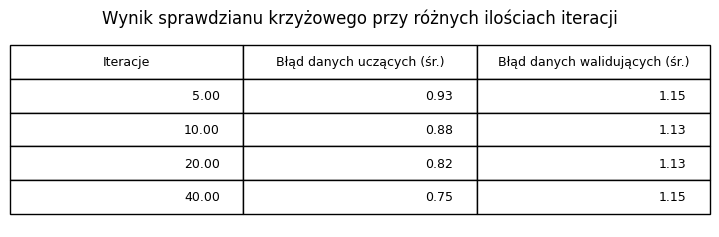

In [6]:
cross_validation_result_iter = [[round(j, 2) for j in i] for i in cross_validation_result_iter]
fig, ax = plt.subplots(figsize=(10,5))
table_data = [['{:.2f}'.format(j) for j in i] for i in cross_validation_result_iter]
table = plt.table(cellText=table_data, colLabels=['Iteracje', 'Błąd danych uczących (śr.)', 'Błąd danych walidujących (śr.)'], loc='center')
table.scale(1,4)
plt.title('Wynik sprawdzianu krzyżowego przy różnych ilościach iteracji')
plt.subplots_adjust(left=0.2, top=0.5)
plt.axis('off')
plt.show()

Test różnych ilości ukrytych czynników

In [12]:
testing_factors = [6, 12, 24, 48]

In [10]:
tf_training_data, tf_validation_data = cross_validation_data[0]
mfs = [MatrixFactorization(tf_training_data, latent_factors=latent_factors, learning_rate=0.005, iterations=20, random_seed=42) for latent_factors in testing_factors]
test_results = run_mfs(mfs)

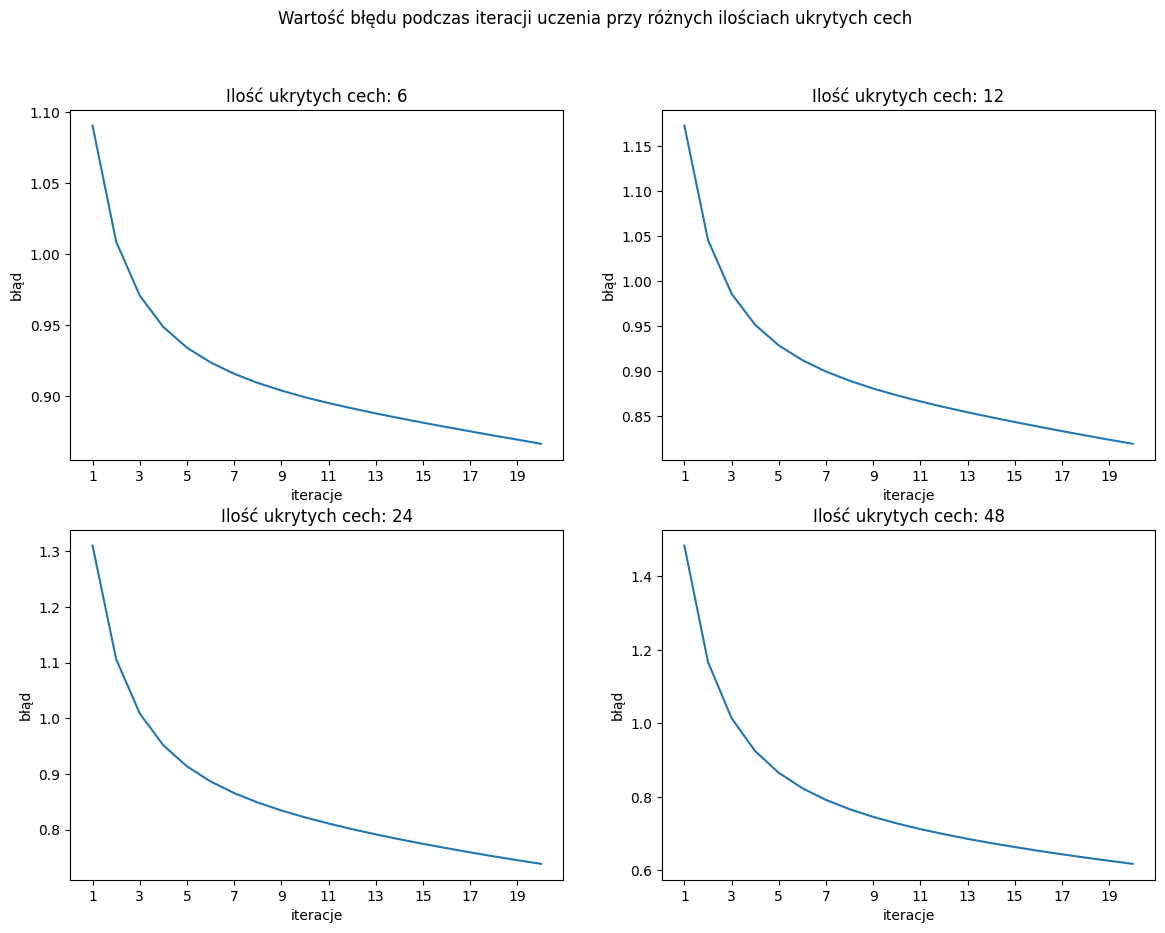

In [11]:
fig = plt.figure(figsize=(14,10))
fig.suptitle('Wartość błędu podczas iteracji uczenia przy różnych ilościach ukrytych cech')
for index, result in enumerate(test_results):
    ax = fig.add_subplot(2,2,index+1)
    mf, error = result
    ax.plot(np.arange(1, len(error)+1), error)
    ax.set_xticks(np.arange(1, len(error)+1 ,2))
    ax.set_title('Ilość ukrytych cech: '+str(mf.get_parameters()['latent_factors']))
    ax.set_xlabel('iteracje')
    ax.set_ylabel('błąd')
plt.show()

In [15]:
testing_factors2 = [4, 6, 12, 24]

In [16]:
tf_training_data, tf_validation_data = cross_validation_data[0]
mfs = [MatrixFactorization(tf_training_data, latent_factors=latent_factors, learning_rate=0.005, regularization=0.1, iterations=20, random_seed=42) for latent_factors in testing_factors2]
test_results = run_mfs(mfs)

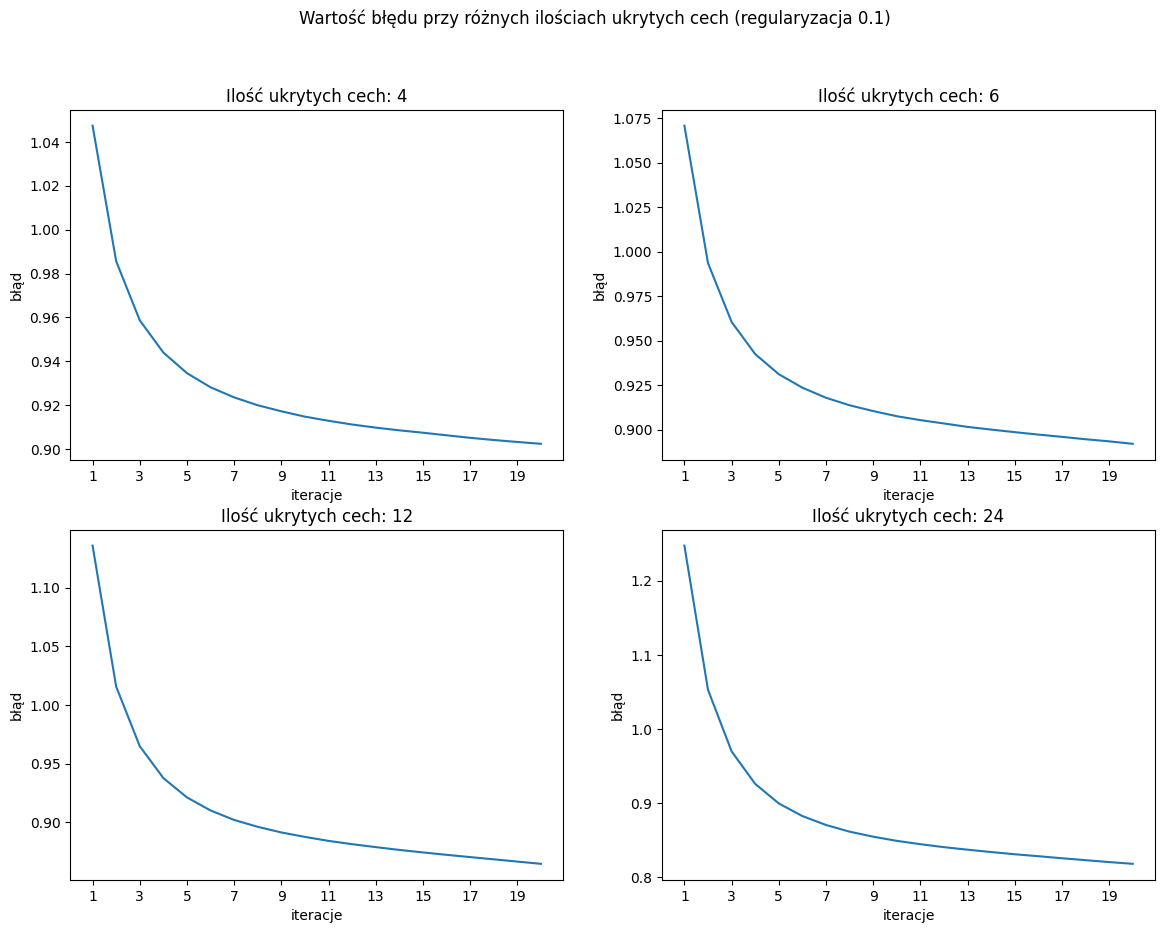

In [17]:
fig = plt.figure(figsize=(14,10))
fig.suptitle('Wartość błędu przy różnych ilościach ukrytych cech (regularyzacja 0.1)')
for index, result in enumerate(test_results):
    ax = fig.add_subplot(2,2,index+1)
    mf, error = result
    ax.plot(np.arange(1, len(error)+1), error)
    ax.set_xticks(np.arange(1, len(error)+1 ,2))
    ax.set_title('Ilość ukrytych cech: '+str(mf.get_parameters()['latent_factors']))
    ax.set_xlabel('iteracje')
    ax.set_ylabel('błąd')
plt.show()

In [12]:
cross_validation_result_lf = []
for factors in testing_factors:
    mfs = []
    for training_data, _ in cross_validation_data:
        mf = MatrixFactorization(training_data, latent_factors=factors, learning_rate=0.005, iterations=20, random_seed=42)
        mfs.append(mf)
    test_results = run_mfs(mfs)
    train_errors = []
    validation_errors = []
    for index, result in enumerate(test_results):
        mf, train_error = result
        training_data, validation_data = cross_validation_data[index]
        validation_error, _, _ = mf.get_rmse_and_similarity(validation_data)
        train_errors.append(train_error[-1])
        validation_errors.append(validation_error)
    train_error_mean = np.array(train_errors).mean()
    validation_error_mean = np.array(validation_errors).mean()
    cross_validation_result_lf.append([factors, train_error_mean, validation_error_mean])
print(cross_validation_result_lf)

[[6, 0.8668928065849041, 1.101191965891126], [12, 0.8212425732628109, 1.1311699784285962], [24, 0.7445963532374442, 1.1936121811238583], [48, 0.6265689558172225, 1.322744030486661]]


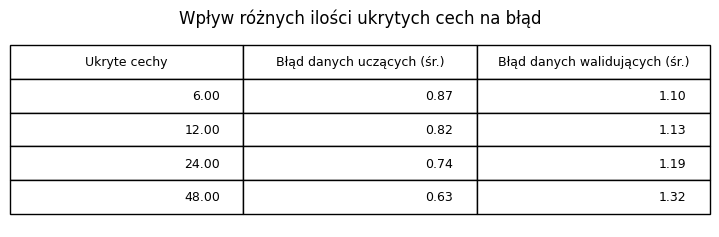

In [13]:
cross_validation_result_lf = [[round(j, 2) for j in i] for i in cross_validation_result_lf]
fig, ax = plt.subplots(figsize=(10,5))
table_data = [['{:.2f}'.format(j) for j in i] for i in cross_validation_result_lf]
table = plt.table(cellText=table_data, colLabels=['Ukryte cechy', 'Błąd danych uczących (śr.)', 'Błąd danych walidujących (śr.)'], loc='center')
table.scale(1,4)
plt.title('Wpływ różnych ilości ukrytych cech na błąd')
plt.subplots_adjust(left=0.2, top=0.5)
plt.axis('off')
plt.show()

In [18]:
cross_validation_result_lf_r = []
for factors in testing_factors2:
    mfs = []
    for training_data, _ in cross_validation_data:
        mf = MatrixFactorization(training_data, latent_factors=factors, regularization=0.1, learning_rate=0.005, iterations=20, random_seed=42)
        mfs.append(mf)
    test_results = run_mfs(mfs)
    train_errors = []
    validation_errors = []
    for index, result in enumerate(test_results):
        mf, train_error = result
        training_data, validation_data = cross_validation_data[index]
        validation_error, _, _ = mf.get_rmse_and_similarity(validation_data)
        train_errors.append(train_error[-1])
        validation_errors.append(validation_error)
    train_error_mean = np.array(train_errors).mean()
    validation_error_mean = np.array(validation_errors).mean()
    cross_validation_result_lf_r.append([factors, train_error_mean, validation_error_mean])
print(cross_validation_result_lf_r)

[[4, 0.9024058394946097, 1.0647442654876027], [6, 0.8930535165606871, 1.0677813523247839], [12, 0.8664732684429504, 1.0734199148172707], [24, 0.8223361194451886, 1.0851597722275796]]


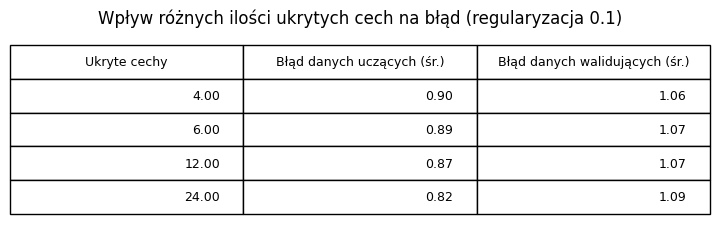

In [19]:
cross_validation_result_lf_r = [[round(j, 2) for j in i] for i in cross_validation_result_lf_r]
fig, ax = plt.subplots(figsize=(10,5))
table_data = [['{:.2f}'.format(j) for j in i] for i in cross_validation_result_lf_r]
table = plt.table(cellText=table_data, colLabels=['Ukryte cechy', 'Błąd danych uczących (śr.)', 'Błąd danych walidujących (śr.)'], loc='center')
table.scale(1,4)
plt.title('Wpływ różnych ilości ukrytych cech na błąd (regularyzacja 0.1)')
plt.subplots_adjust(left=0.2, top=0.5)
plt.axis('off')
plt.show()

Test momentum

In [5]:
mf_momentum = MatrixFactorization(training_data, latent_factors=4, learning_rate=0.005, regularization=0.1, iterations=20, random_seed=42, momentum=0.3)
mf_no_momentum = MatrixFactorization(training_data, latent_factors=4, learning_rate=0.005, regularization=0.1, iterations=20, random_seed=42, momentum=0)
error_momentum = mf_momentum.train()
error_no_momentum = mf_no_momentum.train()

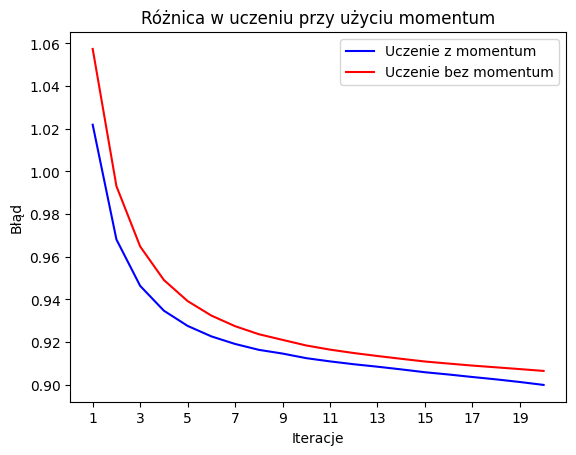

In [7]:
plt.plot(np.arange(1, len(error_momentum)+1), error_momentum, 'b-', label="Uczenie z momentum")
plt.plot(np.arange(1, len(error_momentum)+1), error_no_momentum, 'r-', label = "Uczenie bez momentum")
plt.legend()
plt.xticks(np.arange(1, len(error_momentum)+1 ,2))
plt.title('Różnica w uczeniu przy użyciu momentum')
plt.xlabel('Iteracje')
plt.ylabel('Błąd')
plt.show()

In [23]:
testing_momentum = [0.1, 0.2, 0.3, 0.4]

In [24]:
cross_validation_result_m = []
for momentum in testing_momentum:
    mfs = []
    for training_data, _ in cross_validation_data:
        mf = MatrixFactorization(training_data, latent_factors=4, regularization=0.1, learning_rate=0.005, iterations=20, random_seed=42, momentum=momentum)
        mfs.append(mf)
    test_results = run_mfs(mfs)
    train_errors = []
    validation_errors = []
    for index, result in enumerate(test_results):
        mf, train_error = result
        training_data, validation_data = cross_validation_data[index]
        validation_error, _, _ = mf.get_rmse_and_similarity(validation_data)
        train_errors.append(train_error[-1])
        validation_errors.append(validation_error)
    train_error_mean = np.array(train_errors).mean()
    validation_error_mean = np.array(validation_errors).mean()
    cross_validation_result_m.append([momentum, train_error_mean, validation_error_mean])
print(cross_validation_result_m)

[[0.1, 0.9044612543015462, 1.0650158560499539], [0.2, 0.9024058394946097, 1.0647442654876027], [0.3, 0.8997536565877808, 1.0644187757462944], [0.4, 0.8959545908732984, 1.063973104520417]]


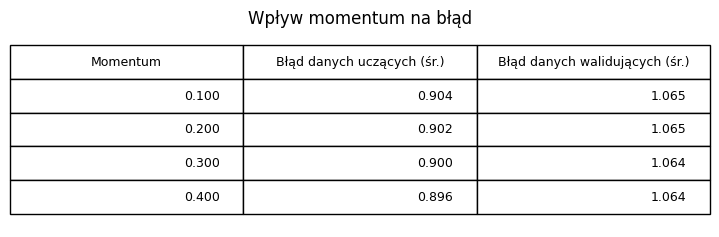

In [25]:
cross_validation_result_m = [[round(j, 3) for j in i] for i in cross_validation_result_m]
fig, ax = plt.subplots(figsize=(10,5))
table_data = [['{:.3f}'.format(j) for j in i] for i in cross_validation_result_m]
table = plt.table(cellText=table_data, colLabels=['Momentum', 'Błąd danych uczących (śr.)', 'Błąd danych walidujących (śr.)'], loc='center')
table.scale(1,4)
plt.title('Wpływ momentum na błąd')
plt.subplots_adjust(left=0.2, top=0.5)
plt.axis('off')
plt.show()

Ponowny test iteracji z dostrojonymi parametrami

In [10]:
test_iterations_r = [20, 30, 40, 50]

In [11]:
final_iter_test_result = []
mfs = []
iter_training, iter_validation = cross_validation_data[0]
for iterations in test_iterations_r:
    mf = MatrixFactorization(iter_training, latent_factors=4, learning_rate=0.005, regularization=0.1, iterations=iterations, random_seed=42, momentum=0.3)
    mfs.append(mf)
test_results = run_mfs(mfs)
for result in test_results:
    mf, train_error = result
    validation_error, _, _ = mf.get_rmse_and_similarity(iter_validation)
    iterations = mf.get_parameters()['train_iterations']
    final_iter_test_result.append([iterations, train_error[-1], validation_error])
print(final_iter_test_result)

[[20, 0.900250740237634, 1.0669508750630645], [30, 0.8879981412570992, 1.0639670283794749], [40, 0.8739424821751739, 1.0608992306987433], [50, 0.8612413969011733, 1.061598978973933]]


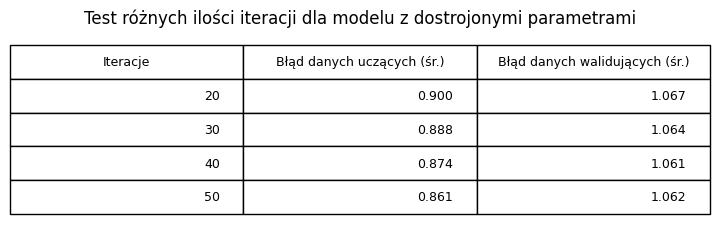

In [14]:
final_iter_test_result = [[round(j, 3) for j in i] for i in final_iter_test_result]
fig, ax = plt.subplots(figsize=(10,5))
# table_data = [['{:.3f}'.format(j) for j in i] for i in cross_validation_result_iter_r]
table_data = [[str(int(i[0]))] + ['{:.3f}'.format(j) for j in i[1:]] for i in final_iter_test_result]
table = plt.table(cellText=table_data, colLabels=['Iteracje', 'Błąd danych uczących (śr.)', 'Błąd danych walidujących (śr.)'], loc='center')
table.scale(1,4)
plt.title('Test różnych ilości iteracji dla modelu z dostrojonymi parametrami')
plt.subplots_adjust(left=0.2, top=0.5)
plt.axis('off')
plt.show()

Test faktoryzacji z dostrojonymi parametrami

In [4]:
mf_all_params = MatrixFactorization(training_data, latent_factors=4, learning_rate=0.005, regularization=0.1, iterations=40, random_seed=42, momentum=0.3)
error_all_params = mf_all_params.train()

In [7]:
rmse, rmse_user, similarities = mf_all_params.get_rmse_and_similarity(test_data)
print(rmse)

1.0144959962021094


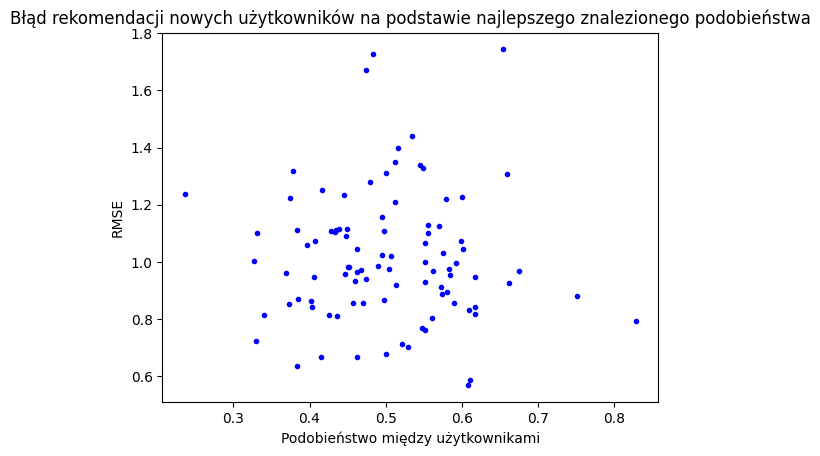

In [17]:
plt.plot(similarities, rmse_user, 'b.')
plt.ylabel("RMSE")
plt.xlabel("Podobieństwo między użytkownikami")
plt.title("Błąd rekomendacji nowych użytkowników na podstawie najlepszego znalezionego podobieństwa")
plt.show()

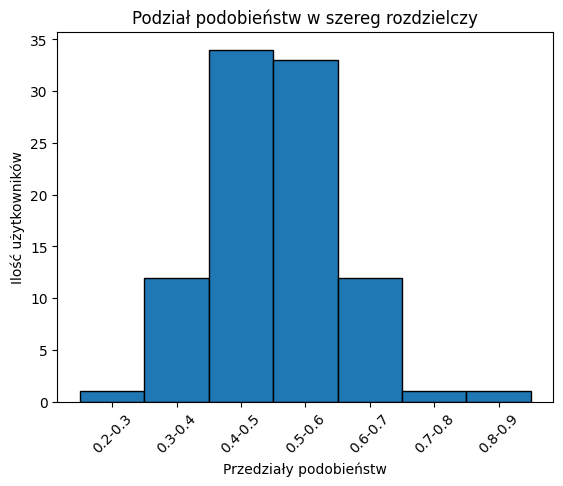

In [18]:
bins = np.arange(0.2, 1.0, 0.1)
hist, bin_edges = np.histogram(similarities, bins=bins)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_midpoints, hist, width=0.1, align='center', edgecolor='black')
plt.xticks(bin_midpoints, labels=[f"{edge:.1f}-{bin_edges[i+1]:.1f}" for i, edge in enumerate(bin_edges[:-1])], rotation=45)
plt.title('Podział podobieństw w szereg rozdzielczy')
plt.xlabel('Przedziały podobieństw')
plt.ylabel('Ilość użytkowników')
plt.show()

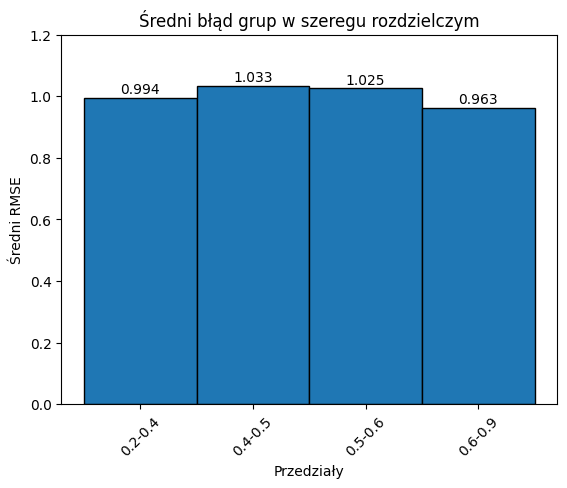

In [10]:
# bins = np.arange(0.2, 1.0, 0.1)
bins = np.array([0.2, 0.4, 0.5, 0.6, 0.9])
grouped_rmse = []
rmse_user = np.array(rmse_user)
for i in range(len(bins) - 1):
    indices = np.where((similarities >= bins[i]) & (similarities < bins[i+1]))[0]
    mean_rmse_group = rmse_user[indices].mean() if indices.size > 0 else np.nan
    grouped_rmse.append(mean_rmse_group)
bin_midpoints = [0.35, 0.45, 0.55, 0.65]
bars = plt.bar(bin_midpoints, grouped_rmse, width=0.1, align='center', edgecolor='black')
plt.xticks(bin_midpoints, labels=[f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)], rotation=45)
plt.ylim(bottom=0, top=1.2)
plt.title('Średni błąd grup w szeregu rozdzielczym')
plt.xlabel('Przedziały')
plt.ylabel('Średni RMSE')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3),  # Adjust 0.005 if needed
             ha='center', va='bottom')
plt.show()

Test rekomendacji

In [32]:
sample_user = test_data[0,:]

In [12]:
rmse, rmse_user, similarities = mf_all_params.get_rmse_and_similarity([sample_user])
print(rmse)

1.225093933895281


In [13]:
print(similarities)

[0.37381011]


In [14]:
sample_user_recommendations = mf_all_params.recommend_for_new_users(np.array([sample_user]))[0]
sample_user_recommendations

array([3.79231741, 3.37125438, 3.9555566 , ..., 2.93391731, 2.96753673,
       2.51193119])

In [17]:
sample_user[sample_user < 3] = 0
sample_user_ids = np.nonzero(sample_user)[0]
sorted_indexes = np.argsort(sample_user_recommendations)[::-1]
sample_user_recommendations_ids = sorted_indexes[:250]

In [9]:
movies = provider.get_movies()

def get_movies_data(movie_ids, with_rates = False):
    movie_ids = [int(id) for id in movie_ids]
    data = movies.iloc[movie_ids]
    if with_rates:
        rates = (data.iloc[:,6:-1].mean()*100).round(2)
        return data, rates
    else:
        return data

In [19]:
chosen_movies, chosen_rates = get_movies_data(sample_user_ids, with_rates=True)
recommended_movies, recommended_rates = get_movies_data(sample_user_recommendations_ids, with_rates=True)
categories = movies.columns[6:-1]

category_rates = list(zip(categories, recommended_rates, chosen_rates))
sorted_category_rates = sorted(category_rates, key=lambda x: x[1], reverse=True)

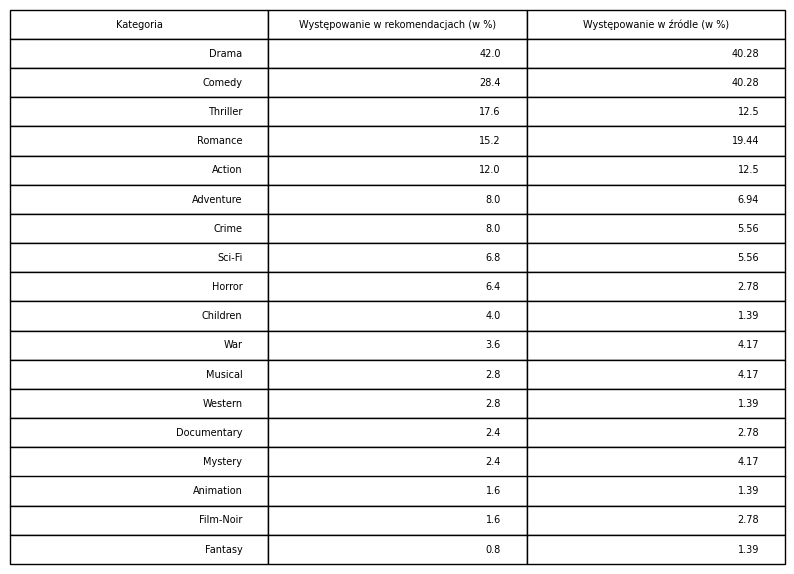

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
table = plt.table(cellText=sorted_category_rates, colLabels=['Kategoria', 'Występowanie w rekomendacjach (w %)', 'Występowanie w źródle (w %)'], loc='center')
table.scale(1, 1.75)
ax.axis('off')
plt.show()

Test drugiej funkcji rekomendacji

In [5]:
rmse, rmse_user, similarities = mf_all_params.get_rmse_and_similarity_pm(test_data)
print(rmse)

1.051833337190588


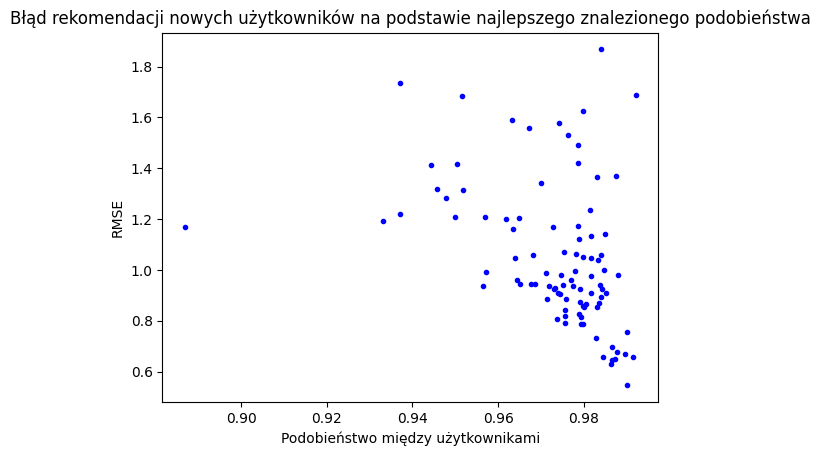

In [6]:
plt.plot(similarities, rmse_user, 'b.')
plt.ylabel("RMSE")
plt.xlabel("Podobieństwo między użytkownikami")
plt.title("Błąd rekomendacji nowych użytkowników na podstawie najlepszego znalezionego podobieństwa")
plt.show()

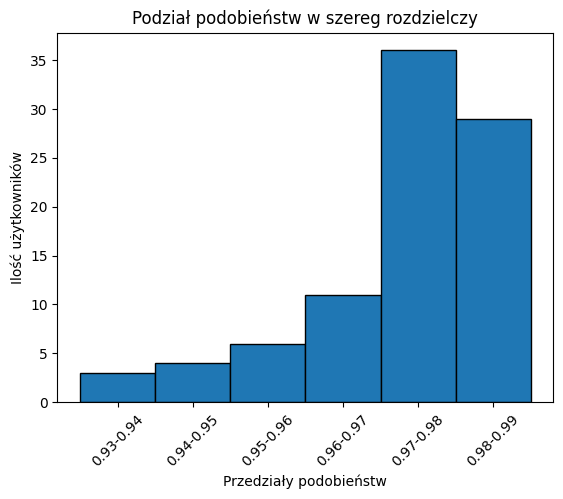

In [13]:
bins = np.arange(0.93, 1.0, 0.01)
hist, bin_edges = np.histogram(similarities, bins=bins)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_midpoints, hist, width=0.01, align='center', edgecolor='black')
plt.xticks(bin_midpoints, labels=[f"{edge:.2f}-{bin_edges[i+1]:.2f}" for i, edge in enumerate(bin_edges[:-1])], rotation=45)
plt.title('Podział podobieństw w szereg rozdzielczy')
plt.xlabel('Przedziały podobieństw')
plt.ylabel('Ilość użytkowników')
plt.show()

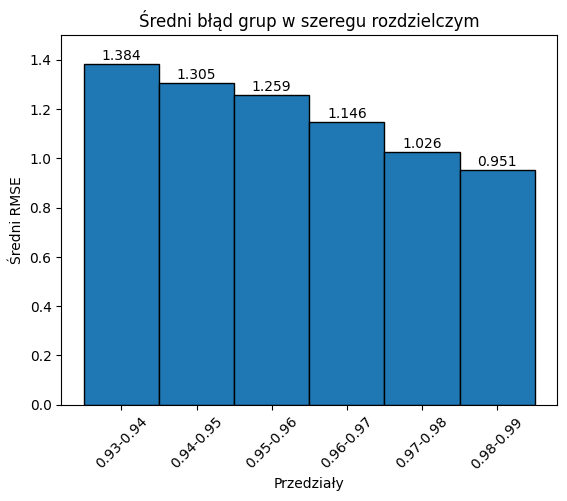

In [17]:
# bins = np.array([0.2, 0.4, 0.5, 0.6, 0.9])
grouped_rmse = []
rmse_user = np.array(rmse_user)
for i in range(len(bins) - 1):
    indices = np.where((similarities >= bins[i]) & (similarities < bins[i+1]))[0]
    mean_rmse_group = rmse_user[indices].mean() if indices.size > 0 else np.nan
    grouped_rmse.append(mean_rmse_group)
bars = plt.bar(bin_midpoints, grouped_rmse, width=0.01, align='center', edgecolor='black')
plt.xticks(bin_midpoints, labels=[f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)], rotation=45)
plt.ylim(bottom=0, top=1.5)
plt.title('Średni błąd grup w szeregu rozdzielczym')
plt.xlabel('Przedziały')
plt.ylabel('Średni RMSE')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3),  # Adjust 0.005 if needed
             ha='center', va='bottom')
plt.show()

In [33]:
rmse, rmse_user, similarities = mf_all_params.get_rmse_and_similarity_pm([sample_user])
print(rmse)

0.7446050767720315


In [34]:
print(similarities)

[0.98365627]


In [35]:
sample_user_recommendations = mf_all_params.recommend_for_new_users_pm(np.array([sample_user]))[0]
sample_user_recommendations

array([4.49473907, 4.2030096 , 4.24591742, ..., 3.83722308, 3.49105231,
       3.88233977])

In [39]:
sample_user[sample_user < 3] == 0
sample_user_ids = np.nonzero(sample_user)[0]
sorted_indexes = np.argsort(sample_user_recommendations)[::-1]
sample_user_recommendations_ids = sorted_indexes[:250]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
chosen_movies, chosen_rates = get_movies_data(sample_user_ids, with_rates=True)
recommended_movies, recommended_rates = get_movies_data(sample_user_recommendations_ids, with_rates=True)
categories = movies.columns[6:-1]

category_rates = list(zip(categories, recommended_rates, chosen_rates))
sorted_category_rates = sorted(category_rates, key=lambda x: x[1], reverse=True)

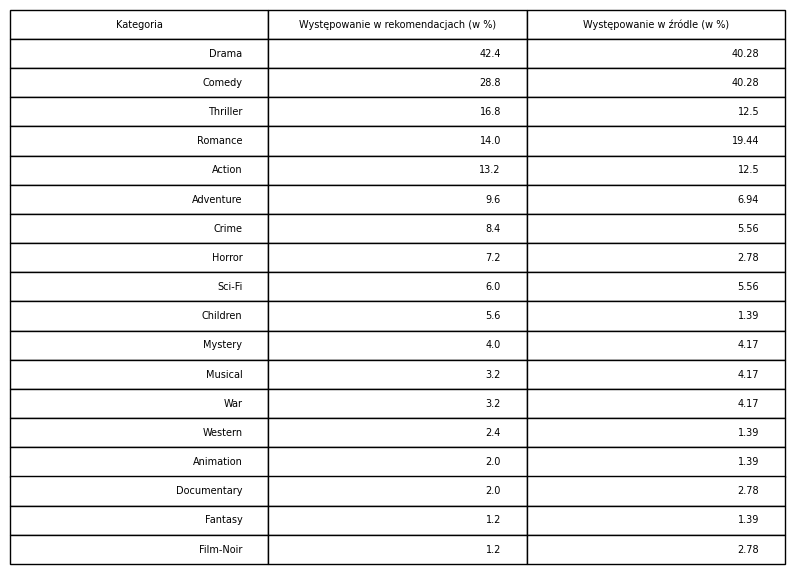

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
table = plt.table(cellText=sorted_category_rates, colLabels=['Kategoria', 'Występowanie w rekomendacjach (w %)', 'Występowanie w źródle (w %)'], loc='center')
table.scale(1, 1.75)
ax.axis('off')
plt.show()